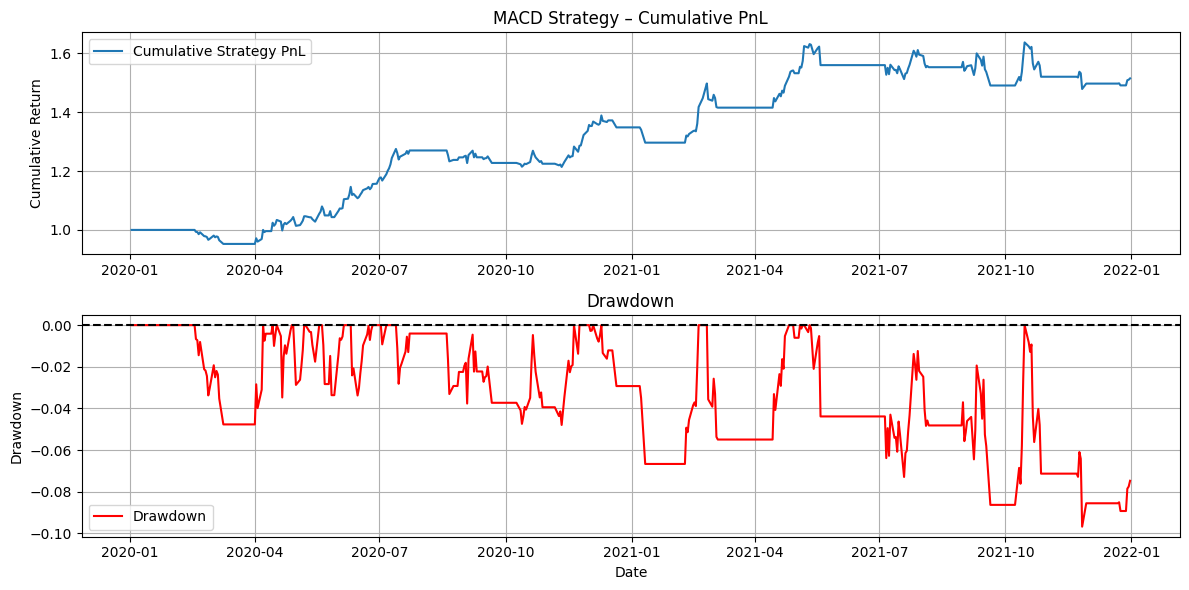

Final Cumulative Return: 1.52x
Annualized Sharpe Ratio: 1.39
Max Drawdown: -9.67%


In [4]:
import pandas as pd
import numpy as np
from ta.trend import MACD
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load and clean price data
# -----------------------------

# Load historical Copper prices from CSV
df = pd.read_csv('../data/MarketData.csv', skiprows=6)

# Rename relevant column and keep only what we need
df.rename(columns={
    'Dates': 'Date',
    'PX_SETTLE': 'Copper',
}, inplace=True)
df = df[['Date', 'Copper']]

# Convert 'Date' to datetime format and filter for 2020 and 2021
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df[df['Date'].dt.year.isin([2020, 2021])].copy()

# Drop rows with missing data and set Date as index
df.dropna(inplace=True)
df.set_index('Date', inplace=True)

# -----------------------------------------------
# 2. Strategy: Use MACD crossover as a trade signal
# -----------------------------------------------

# We use the MACD (Moving Average Convergence Divergence) indicator,
# which captures momentum based on the difference between two EMAs.
# - When MACD crosses above the signal line → bullish (go long)
# - When MACD crosses below the signal line → bearish (exit position)

# Create MACD object with standard parameters (fast=12, slow=26, signal=9)
macd = MACD(close=df['Copper'], window_fast=12, window_slow=26, window_sign=9)

# Store MACD line and Signal line in the dataframe
df['MACD'] = macd.macd()
df['Signal'] = macd.macd_signal()

# --------------------------------------------------
# 3. Generate trading signals based on MACD crossovers
# --------------------------------------------------

# Create a binary column: 1 = go long, 0 = stay out
# Signal is triggered when MACD > Signal line
df['Signal_Trigger'] = (df['MACD'] > df['Signal']).astype(int)

# Create the actual position: we enter the trade at next day's open
# So we shift the signal by 1 to avoid forward-looking bias
df['Position'] = df['Signal_Trigger'].shift(1).ffill().fillna(0)

# --------------------------------------
# 4. Compute strategy and benchmark returns
# --------------------------------------

# Daily return of Copper
df['Daily_Return'] = df['Copper'].pct_change()

# Strategy return: only earn return if we are "in" the market
df['Strategy_Return'] = df['Daily_Return'] * df['Position']

# -------------------------------------------------
# 5. Compute cumulative PnL and drawdowns over time
# -------------------------------------------------

# Cumulative performance (PnL): start from 1 and multiply returns
df['Cumulative_PnL'] = (1 + df['Strategy_Return']).cumprod()

# Track historical peak of cumulative PnL to measure drawdowns
df['Cumulative_Peak'] = df['Cumulative_PnL'].cummax()

# Drawdown = % decline from previous peak
df['Drawdown'] = df['Cumulative_PnL'] / df['Cumulative_Peak'] - 1

# -------------------------------------------------
# 6. Compute Sharpe ratio to measure risk-adjusted return
# -------------------------------------------------

# Annualized Sharpe Ratio: mean return / std dev of return × sqrt(252)
# 252 = number of trading days in a year
sharpe_ratio = (df['Strategy_Return'].mean() / df['Strategy_Return'].std()) * np.sqrt(252)

# -------------------------------
# 7. Plot PnL and Drawdown curves
# -------------------------------

plt.figure(figsize=(12, 6))

# Top plot: Cumulative returns
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Cumulative_PnL'], label='Cumulative Strategy PnL')
plt.title('MACD Strategy – Cumulative PnL')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()

# Bottom plot: Drawdown
plt.subplot(2, 1, 2)
plt.plot(df.index, df['Drawdown'], color='red', label='Drawdown')
plt.axhline(0, color='black', linestyle='--')
plt.title('Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# -------------------------------------
# 8. Final performance summary printed
# -------------------------------------

print(f"Final Cumulative Return: {df['Cumulative_PnL'].iloc[-1]:.2f}x")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {df['Drawdown'].min():.2%}")
